In [1]:
# get higgs pT target histogram
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
branches = ['LHEWeight_nnlops-11-1', 'Generator_weight', 'GenPart_pdgId', 'GenPart_pt', 'GenPart_status', 'LHEScaleWeight', 'nJet']

files = uproot.iterate('/storage/user/christiw/login-1/christiw/LLP/GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8/nano_mc_2018_*.root',"Events", branches)
# create TH1D
weight = []
higgsPt = []
nJet  = []
weight_unc = {}

for i in range(9): weight_unc[i] = []
for i,tree in enumerate(files):
    nJet += list(tree[b'nJet'])
    gParticlePt = tree[b'GenPart_pt']
    gParticleId = tree[b'GenPart_pdgId']
    gParticleStatus = tree[b'GenPart_status']
    higgs_sel = np.logical_and(gParticleId == 25, gParticleStatus == 62)
    assert(np.count_nonzero(higgs_sel.sum() == 1)== len(higgs_sel)) #make sure one higgs per event
    higgsPt += (list(gParticlePt[higgs_sel].flatten()))
    weight += (list(tree[b'LHEWeight_nnlops-11-1'].flatten()* tree[b'Generator_weight'].flatten()))
    for j in range(9):
        weight_unc[j] += list(tree[b'LHEWeight_nnlops-11-1'].flatten()* tree[b'Generator_weight'].flatten() * tree[b'LHEScaleWeight'][:,j].flatten())
    if i%100 == 0:print(i, len(weight))

0 40000
100 4040000
200 8040000
300 12040000


In [3]:
# load source file
source_file = rt.TFile.Open('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ggH_HiggsPtSource.root', 'READ')
source = source_file.Get("higgsPt")
source.Scale(1./source.Integral())

target_file = rt.TFile.Open('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ggH_HiggsPtTarget_NNLOPS.root', 'READ')
# target_file = rt.TFile.Open('/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ggH_HiggsPtTarget_NNLOPS_Sys5.root', 'READ')


target = target_file.Get("higgsPt")
target.Scale(1./target.Integral())
# weight = target.Clone()
# weight.Divide(source)




0.15660327672958374
0.15391558405800268
5.0 0.9828375706581027
15.0 0.8296247208029212
25.0 0.9201116573041194
35.0 1.0124781917157422
45.0 1.1018942137318206
55.0 1.1775672710441918
65.0 1.2307445988922074
75.0 1.2855484100314545
85.0 1.3020131074203707
95.0 1.3173490706067181
105.0 1.314200511265848
115.0 1.3149820522732312
125.0 1.2838187178039842
135.0 1.272809934518673
145.0 1.253332983623394
155.0 1.229418219962922
165.0 1.2020713379874686
175.0 1.175248141519182
185.0 1.1581264385098986
195.0 1.1230103654433488
205.0 1.10263368296045
215.0 1.0890459660586123
225.0 1.062000885082362
235.0 1.0728921679450731
245.0 1.0506678335659951
255.0 0.9957300797749644
265.0 1.0025609281015313
275.0 0.9894760587340659
285.0 0.9671746659137644
295.0 0.960588569248073
305.0 0.9467875337495261
315.0 0.9070348157042001
325.0 0.9087561287995014
335.0 0.8596017912481068
345.0 0.8465981322757509
355.0 0.8737448604412018
365.0 0.878063604160044
375.0 0.841940403634866
385.0 0.8809197582001632
395.0 0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


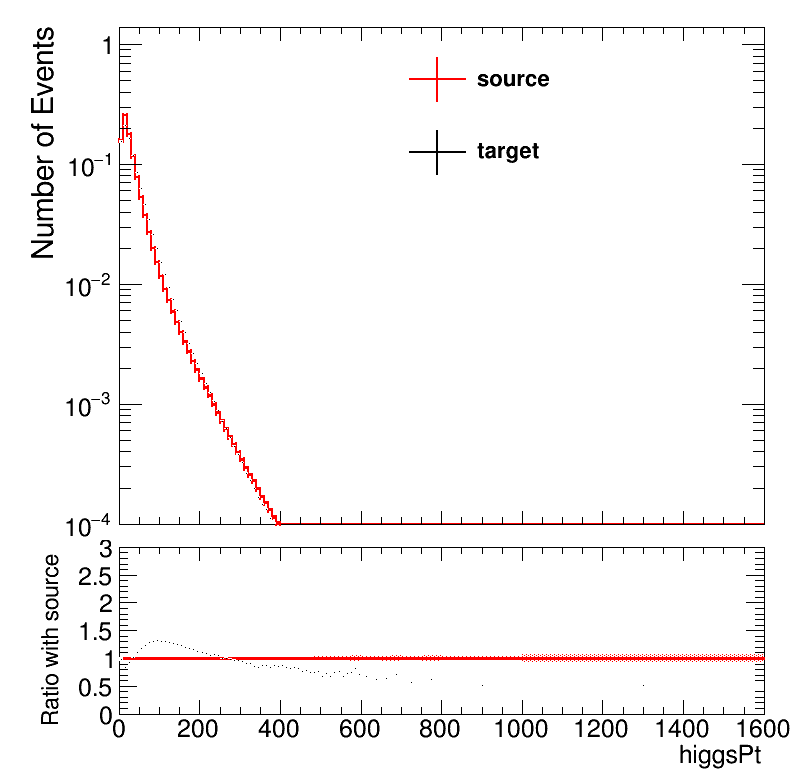

In [4]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


c = rt.TCanvas('c','c', 800, 800)
# rt.gStyle.SetOptFit(1000000)
rt.gStyle.SetOptStat(0)


bins = list(range(0, 600,10))
bins += list(range(600, 700, 25))
bins += list(range(700, 800, 50))
bins += [800]
bins += [1000, 1600]
# target = create_TH1D( higgsPt, axis_title=['higgs pT [GeV]', 'Events'], name='higgsPt', binning=bins, weights = weight)
# source = create_TH1D( higgsPt, axis_title=['higgs pT [GeV]', 'Events'], name='higgsPt', binning=bins, weights = weight_unc[3])

print(source.GetBinContent(1))
print(target.GetBinContent(1))
for i in range(target.GetXaxis().GetNbins()):
    if source.GetBinContent(i)>0:
        print(target.GetBinCenter(i), target.GetBinContent(i)/source.GetBinContent(i))
# histPt.SetMaximum(10E3)
# histPt.SetMinimum(0.1)
target.GetXaxis().SetLabelSize(0.04)
target.SetLineWidth(2)
source.SetLineWidth(2)
target.SetLineColor(1)
source.SetLineColor(2)


target.DrawNormalized('same')
source.DrawNormalized('same')

c = make_ratio_plot([source, target], fit = False, logy=True, in_tags = ["source","target"], ratio_bounds = [0,3], draw_opt = ['E1','E2'])



c.SetLogy()
c.SetRightMargin(0)
c.Draw()
# print(time.time()-start_t)

1300.0


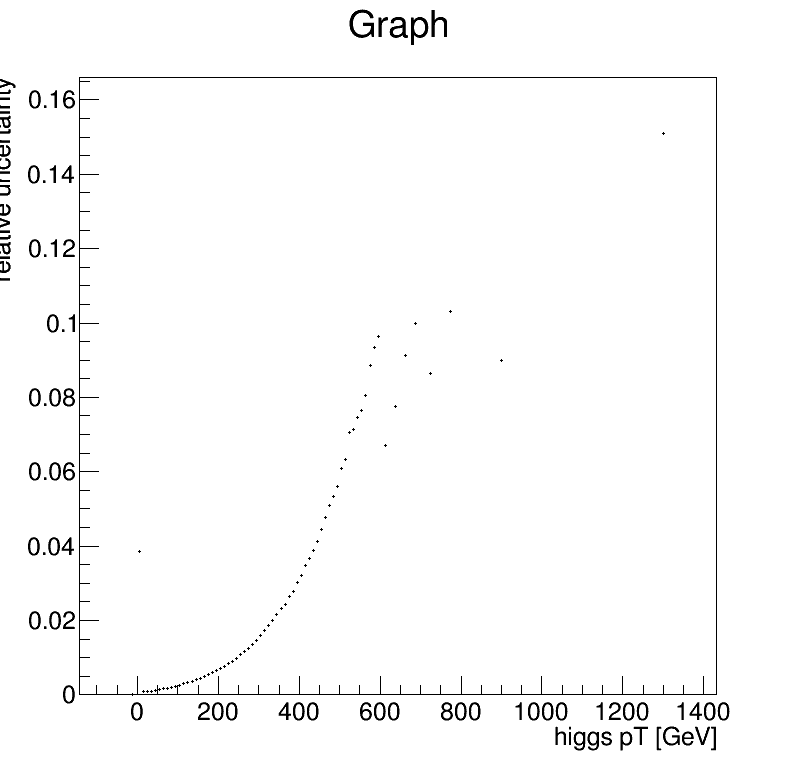

In [47]:
# plot relative uncertainty
c = rt.TCanvas('c','c', 800, 800)

weight_hist = target.Clone()
weight_hist.Divide(source)
relative_unc = []
bin_center = []
for i in range(weight_hist.GetXaxis().GetNbins()+1):
    if weight_hist.GetBinContent(i) == 0: relative_unc.append(0.0)
    else: relative_unc.append(weight_hist.GetBinError(i)/weight_hist.GetBinContent(i))
    bin_center.append(weight_hist.GetBinCenter(i))
unc = create_TGraph(bin_center, relative_unc,  axis_title=['higgs pT [GeV]', 'relative uncertainty'])
unc.SetMarkerSize(6)
unc.SetMarkerStyle(6)

print(bin_center[-1])
unc.Draw('ap')
c.Draw()

In [44]:
source_file = rt.TFile.Open('/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ggH_HiggsPtSource_200_1600.root', 'READ')
source = source_file.Get("higgsPt")

target = create_TH1D( higgsPt, axis_title=['higgs pT [GeV]', 'Events'], name='higgsPt', binning=[200,0,1600], weights = weight_unc[1]/np.sum(weight_unc[1]))

weight = target.Clone()
weight.Divide(source)



True

Warning in <TFile::Append>: Replacing existing TH1: higgsPt (Potential memory leak).


In [8]:
relative_unc = []
bin_center = []
for i in range(1, weight.GetXaxis().GetNbins()+1):
    if i <=75:
        if weight.GetBinContent(i) == 0: relative_unc.append(0.0)
        else: relative_unc.append(weight.GetBinError(i)/weight.GetBinContent(i))
        bin_center.append(weight.GetBinCenter(i))
    elif i <=87: #700
        if (i-76)%3 == 0:
            nominator = target.GetBinContent(i) + target.GetBinContent(i+1) + target.GetBinContent(i+2)
            denominator = source.GetBinContent(i) + source.GetBinContent(i+1) + source.GetBinContent(i+2)
            if nominator == 0 or denominator == 0: 
                relative_unc.append(0)
            else:
                nom_err = (target.GetBinError(i)**2 + target.GetBinError(i+1)**2 + target.GetBinError(i+2)**2)**0.5/nominator # relative error
                denom_err = (source.GetBinError(i)**2 + source.GetBinError(i+1)**2 + source.GetBinError(i+2)**2)**0.5/denominator # relative error
                relative_unc.append((denom_err**2+nom_err**2)**0.5)
            bin_center.append(source.GetBinCenter(i+1)) 
        else: continue
    elif i <=129:#1000
        if (i-88)%6 == 0:
            nominator = 0
            denominator = 0
            nom_err = 0
            denom_err = 0
            for j in range(6):
                nominator += target.GetBinContent(i+j)
                denominator += source.GetBinContent(i+j)
#                 nom_err = target.GetBinError(i+j)**2
#                 denom_err = source.GetBinError(i+j)**2
            if nominator == 0 or denominator == 0: 
                relative_unc.append(0.0)
            else:
#                 nom_err = nom_err**0.5/nominator
#                 denom_err = denom_err**0.5/denominator
                nom_err = nominator**0.5/nominator
                denom_err = denominator**0.5/denominator
                relative_unc.append((denom_err**2+nom_err**2)**0.5)
            bin_center.append(source.GetBinCenter(i+2)+source.GetBinWidth(1)/2)
            print(i, bin_center[-1], relative_unc[-1])
        else: continue

    elif (i-130)%75 == 0 and i <200:
        nominator = 0
        denominator = 0
        nom_err = 0
        denom_err = 0
        for j in range(75):
            nominator += target.GetBinContent(i+j)
            denominator += source.GetBinContent(i+j)
            nom_err = target.GetBinError(i+j)**2
            denom_err = source.GetBinError(i+j)**2
        if nominator == 0 or denominator == 0: 
            relative_unc.append(0.0)
        else:
            nom_err = nom_err**0.5/nominator
            denom_err = denom_err**0.5/denominator
            relative_unc.append((denom_err**2+nom_err**2)**0.5)
        bin_center.append(source.GetBinCenter(i+37))
        print(i, bin_center[-1], relative_unc[-1])
    else: continue

        

88 720.0 458.8411755520877
94 768.0 0.0
100 816.0 551.0861673349023
106 864.0 0.0
112 912.0 0.0
118 960.0 0.0
124 1008.0 0.0
130 1332.0 0.0


1008.0
0.0


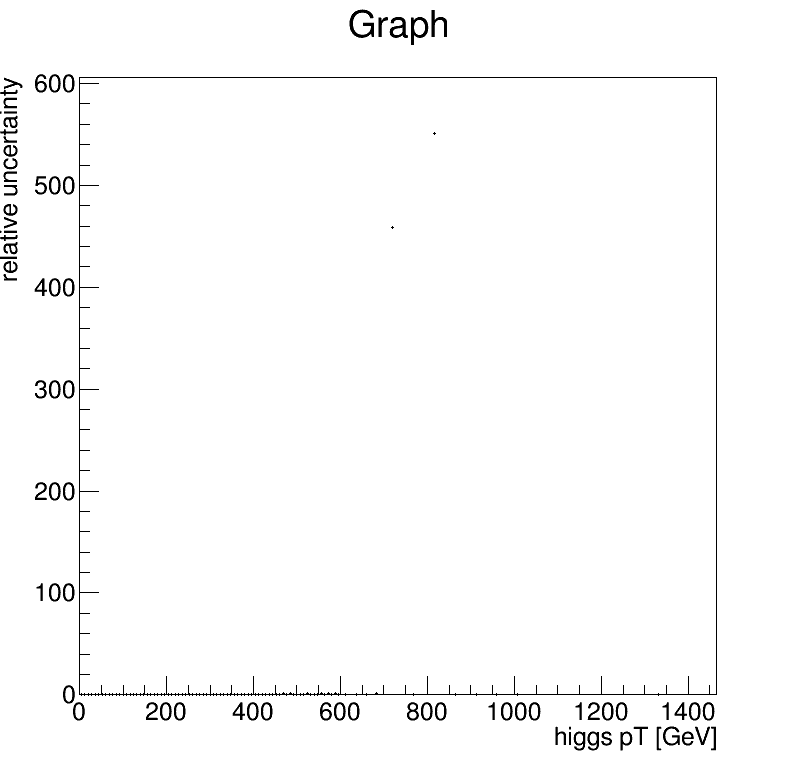

In [9]:
c = rt.TCanvas('c','c', 800, 800)

unc = create_TGraph(bin_center, relative_unc,  axis_title=['higgs pT [GeV]', 'relative uncertainty'])
unc.SetMarkerSize(6)
unc.SetMarkerStyle(6)


unc.Draw('ap')
c.Draw()
print(bin_center[-2])
print(relative_unc[-2])

# output target historgram

In [17]:
from array import array
def Normalize(hist):
    norm = 0.0
    for b in range(hist.GetXaxis().GetNbins()+2):
        norm += hist.GetBinContent(b)
    for b in range(hist.GetXaxis().GetNbins()+2):
        hist.SetBinContent(b, hist.GetBinContent(b)/norm)
        hist.SetBinError(b, hist.GetBinError(b)/norm)

outputDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/'
bins = [200, 0, 1600]

bins = list(range(0, 600,10))
bins += list(range(600, 700, 25))
bins += list(range(700, 800, 50))
bins += [800]
bins += [1000, 1600]

print(bins)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 625, 650, 675, 700, 750, 800, 1000, 1600]


In [19]:
outputFileName = outputDir + 'ggH_HiggsPtTarget_NNLOPS.root'
outFile = rt.TFile(outputFileName, 'RECREATE')

histPt = create_TH1D( higgsPt, axis_title=['higgsPt', 'Events'], name='higgsPt', binning=bins, weights = weight/np.sum(weight))

outFile.WriteTObject(histPt, 'higgsPt', "WriteDelete");
outFile.Close();

In [27]:
for i in range(9):
    outputFileName = outputDir + 'ggH_HiggsPtTarget_NNLOPS_Sys'+str(i)+'.root'
    outFile = rt.TFile(outputFileName, 'RECREATE')
    histPt = create_TH1D( higgsPt, axis_title=['higgsPt', 'Events'], name='higgsPt', binning=bins, weights = weight_unc[i]/np.sum(weight))
    outFile.WriteTObject(histPt, 'higgsPt', "WriteDelete");
    outFile.Close();
    print(i)

NameError: name 'outputDir' is not defined

In [35]:
import ROOT as rt
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

inputDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/'
higgsPt = []
inputFileName = {}
f = {}

for i in range(9):
    inputFileName[i] = inputDir + 'ggH_HiggsPtTarget_NNLOPS_Sys'+str(i)+'.root'
    f[i] = rt.TFile(inputFileName[i],'READ')
    temp = f[i].Get("higgsPt")
    higgsPt.append(f[i].Get("higgsPt"))


0.0775848665285141
0.22843598398556894
0.2522355443026724
0.06817280500506728
0.1539109114235
0.17614002559181943
0.06183967082933995
0.1325224558905097
0.15388532646851702


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/uncertainties/higgsPtReweightSys.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/uncertainties/higgsPtReweightSys.C has been generated


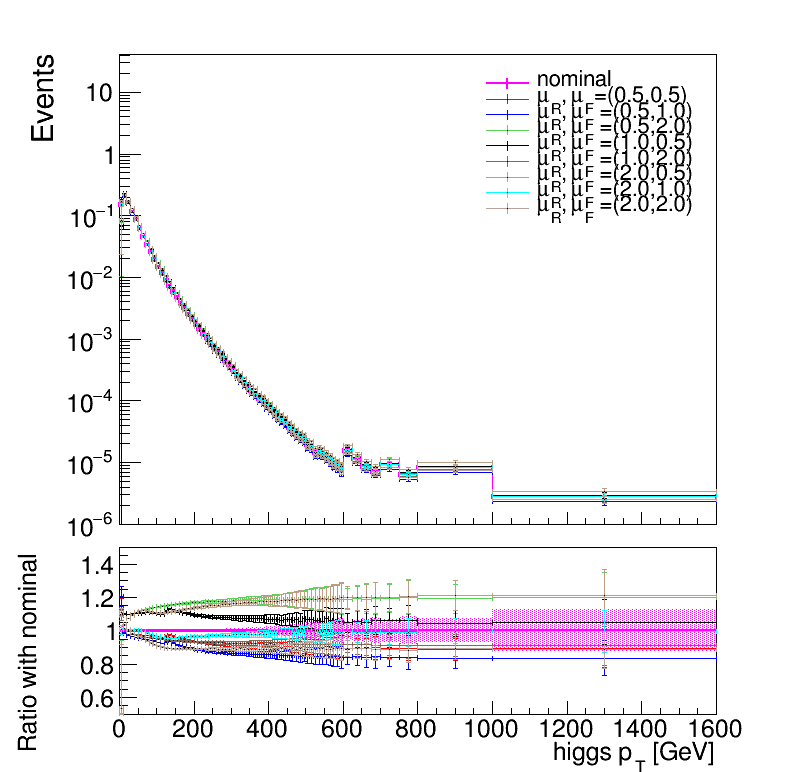

In [36]:
c = rt.TCanvas('c','c', 800, 800)

leg = rt.TLegend(0.60,0.5,0.90,0.89)

leg.SetTextSize(0.2)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

for i in range(9):
    print(higgsPt[i].GetBinContent(1))
    higgsPt[i].SetLineColor(std_color_list[i])
    higgsPt[i].Scale(1./higgsPt[i].Integral())
    higgsPt[i].GetXaxis().SetTitle('higgs p_{T} [GeV]')


#     higgsPt[i].SetMaximum(1)
#     higgsPt[i].SetMinimum(0.0000001)
#     higgsPt[i].Draw('hist same')

higgsPt[0], higgsPt[4] = higgsPt[4], higgsPt[0] 
tags = ['nominal', '#mu_{R}, #mu_{F}=(0.5,0.5)','#mu_{R}, #mu_{F} =(0.5,1.0)','#mu_{R}, #mu_{F} =(0.5,2.0)','#mu_{R}, #mu_{F} =(1.0,0.5)',\
        '#mu_{R}, #mu_{F} =(1.0,2.0)','#mu_{R}, #mu_{F} =(2.0,0.5)','#mu_{R}, #mu_{F} =(2.0,1.0)','#mu_{R}, #mu_{F} =(2.0,2.0)',]


c = make_ratio_plot(higgsPt, fit = False, logy=True, in_tags =tags , ratio_bounds = [0.5,1.5],draw_opt = ['E1']*9) 


c.SetLogy()
c.Draw()
c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/uncertainties/higgsPtReweightSys.png')
c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/uncertainties/higgsPtReweightSys.C')

In [26]:
[str(i) for i in list(range(9))]

['0', '1', '2', '3', '4', '5', '6', '7', '8']